# Alabama Power Model Building Guide
## Building Machine Learning Models with AMI Data
---

## Introduction
In this exercise, we are going to test the skills that you have built during this course by building a model that will detect unusual correlation coefficients within transformer pairings.

It has already been determined that correlation coefficients are helpful for spotting mislabeled transformer/customer pairs [1]. In the table below, `T1-M5` is known to be a mislabeled pair, while the other four pairs are correctly paired. The correlations are for in-ground cables, assumed to be the highest correlations that the grid is likely to see. 

|       | T1-M1 | T1-M2  | T1-M3   | T1-M4 | T1-M5   |
|-------|-------|---|---|---|---|
| T1-M1 | 1.0   |   |   |   |   |
| T1-M2 | 0.97936  | 1.0  |   |   |   |
| T1-M3 | 0.98014  | 0.98239   |1.0   |   |   |
| T1-M4 | 0.97966  | 0.98127  | 0.97980  |  1.0 |   |
| T1-M5 | 0.94359  | 0.94901  | 0.94768  |  0.94893 |  1.0 |

*Source: Transformer_Corr_Function.xlsx Sheet1

We will use the procedure outlined below to identify unusual correlation coefficients within transformer pairings.

### Learning Objectives
* Clean and explore AMI data
* Produce a model to identify unusual correlation coefficients within transformer pairings

## Build a Model with AMI Data

### Step 1: Proof of Concept
Before we apply our methodology to all of the data, let's use a smaller example to refine all of the moving parts.

Start by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import json

from multiprocessing import Pool, cpu_count

Next, encode the correlations from the first data set.

In [2]:
test_corrs = [0.97936, 0.98014, 0.97966, 0.94359, 0.98239, 0.98127, 0.94901, 0.97980, 0.94768, 0.94893]

Next, we can use numPy to gather descriptive statistics that will help us understand the shape of our data.

In [3]:
test_mean = np.mean(test_corrs)

print(f"Test Mean: {test_mean}")

test_std = np.std(test_corrs)

print(f"Test STD: {test_std}")

Test Mean: 0.967183
Test STD: 0.016313032857197325


Finally, let's plot our findings.

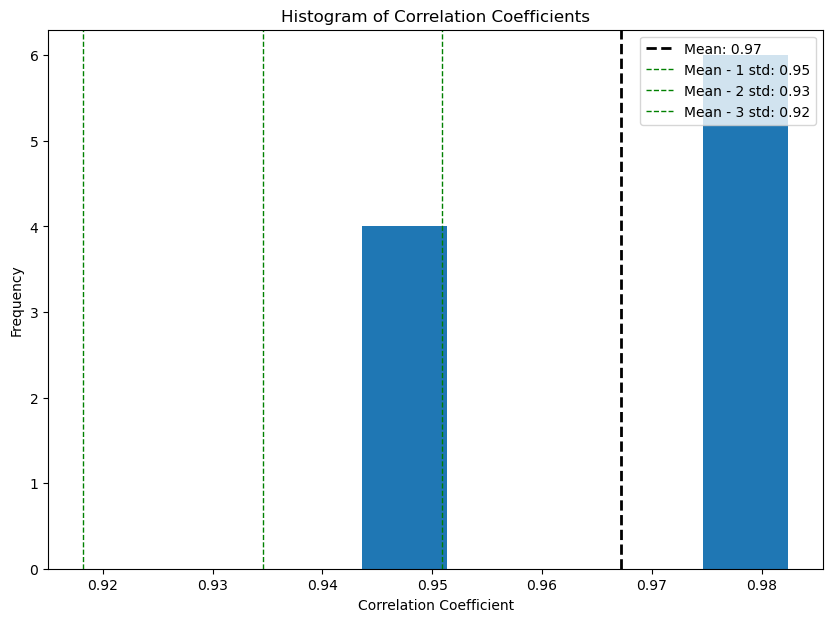

In [4]:
mafig, ax = plt.subplots(figsize =(10, 7))
ax.hist(test_corrs, bins='auto')
plt.axvline(test_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {test_mean:.2f}')


for i in range(1, 4):
    dev = i * test_std
    plt.axvline(test_mean - dev, color='green', linestyle='dashed', linewidth=1, 
                label=f'Mean - {i} std: {test_mean - dev:.2f}')

plt.title('Histogram of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

# Add legend
plt.legend()
    
# Show plot
plt.show()

Because this sample data is so small, we can eyeball the chart. The four lowest correlation coefficients are all associated with `T1-M5`. 

((array([-1.49876728, -0.98494667, -0.64703803, -0.37109819, -0.12121409,
          0.12121409,  0.37109819,  0.64703803,  0.98494667,  1.49876728]),
  array([0.94359, 0.94768, 0.94893, 0.94901, 0.97936, 0.97966, 0.9798 ,
         0.98014, 0.98127, 0.98239])),
 (0.01622355714801302, 0.9671830000000001, 0.865569641049545))

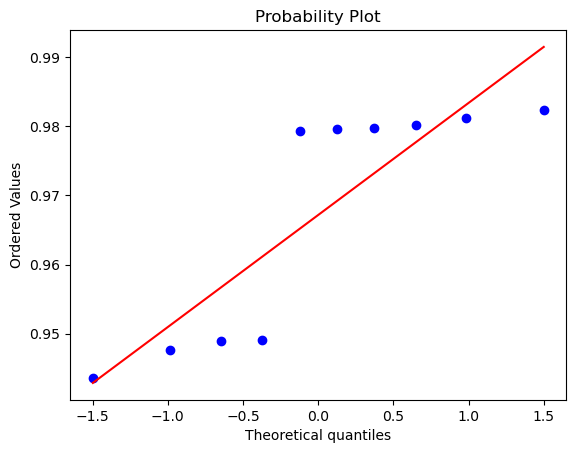

In [5]:
# A probability plot shows us whether a sample is likely drawn from a normal distribution.
# We want to see a mostly straight line.
stats.probplot(test_corrs, plot=plt)

The small (probably too small) sample of correlation coefficients does not indicate normality on this test. We would expect to see an approximately straight line if the data were shown to be normal. This is included here to indicate that some caution around using typical statistical tools may be warranted.

### Step 2: Explore the Data
We know what method we're going to use, but it is still imperative to explore the data to identify nuances and idiosyncracies that may impact our approach.

In [6]:
# 1. Read in the data, assigned to dataframe apc
# apc = pd.read_parquet('./data/Flat_Iron_Dataset_06292023.parquet')
apc = pd.read_parquet("apc.parquet")

In [7]:
# 2. How large is it? Check the shape
apc.shape

(2000000, 5)

In [8]:
# 3. What columns do we have? What do they represent?
apc.columns

Index(['endpoint_id', 'sample_date', 'sample_point', 'voltage', 'fldptag'], dtype='object')

In [9]:
# 4. Do the data types make sense?
apc.dtypes

endpoint_id       int64
sample_date      object
sample_point      int64
voltage         float64
fldptag          object
dtype: object

#### Build a Data Dictionary

81m rows; five columns:  

| Name  | Type  |  Description |    
|  ---  | ---   |  ---  |
| endpoint_id  |  int64 | customer id  |    
| sample_date  | object  | date sample was taken  | 
| sample_point  | int64  | ??  |  
| voltage  | float |  voltage reading at sample_date | 
| fldptag  |  object |  transformer id | 

`Sample_point`'s purpose is unclear, and `sample_date` isn't a timestamp or datetime object. Also, of `endpoint_id` and `fldtptag`, which represents the customer and which the transformer?

#### Fixing `sample_date`
We do know that we are going to be working with timeseries, so we want to get our timestamped column into a datetime object.

In [10]:
# 1. Overwrite `sample_date` with the datetime object
apc['sample_date'] = pd.to_datetime(apc['sample_date'])

In [11]:
# 2. Check that the data type for `sample_date` is datetime
apc.dtypes

endpoint_id              int64
sample_date     datetime64[ns]
sample_point             int64
voltage                float64
fldptag                 object
dtype: object

#### What is `sample_point`?
Not knowing what it is, this seems like as good a time as any for basic variable exploration. See what we've got, and how many.

In [12]:
# 1. Are there any nulls in the original dataframe?
for i in apc.columns:
    print(f"Nulls in {i}:", apc[i].isna().sum())

Nulls in endpoint_id: 0
Nulls in sample_date: 0
Nulls in sample_point: 0
Nulls in voltage: 0
Nulls in fldptag: 0


In [13]:
# 2. What are the unique values?
for i in apc.columns:
    print(f"Unique values in {i}: ", apc[i].nunique())

Unique values in endpoint_id:  7615
Unique values in sample_date:  328
Unique values in sample_point:  328
Unique values in voltage:  3003
Unique values in fldptag:  3051


`Sample_date` and `sample_point` have the same number of unique values.

In [14]:
apc[apc['sample_point']==1682918100].sample_date.nunique()

1

In [15]:
s_points = apc.groupby('sample_point')['sample_date'].nunique()

In [16]:
sum(s_points)

328

So `sample_point` appears to be a unique identifier for the timestamp in `sample_date`.

#### Variables: `fldptag` or `endpoint_id`
Which represents the transformer, which represents the customer?

In [17]:
# Check unique values, again
for i in apc.columns:
    print(f"Unique values in {i}: ", apc[i].nunique())

Unique values in endpoint_id:  7615
Unique values in sample_date:  328
Unique values in sample_point:  328
Unique values in voltage:  3003
Unique values in fldptag:  3051


There's more unique `endpoint_id`s than there are `fldptag`, so presumably `fldptag` represents the transformer and the `endpoint_id` represents the customer. On that basis, let's get a look at how many customers there are for every transformer.

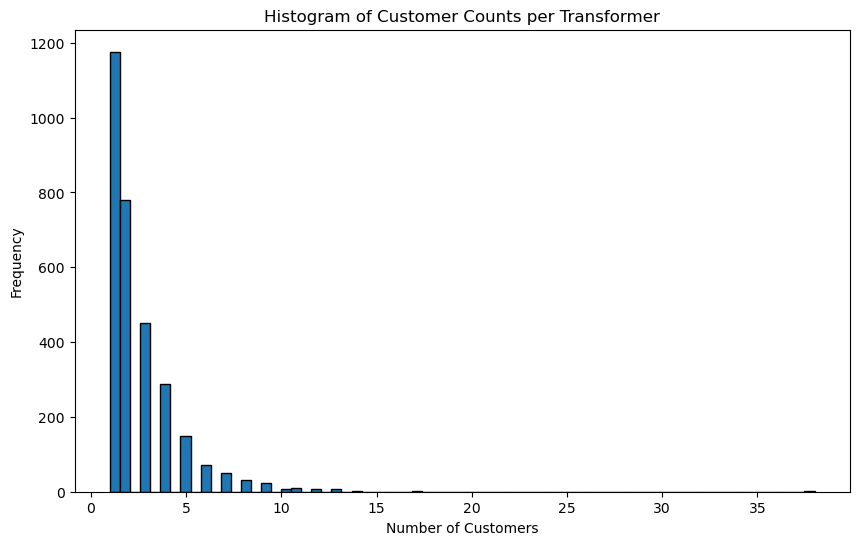

In [18]:
counts = apc.groupby('fldptag')['endpoint_id'].nunique()

# Plot a histogram of these counts
plt.figure(figsize=(10,6))
plt.hist(counts, bins=70, edgecolor='black')
plt.title('Histogram of Customer Counts per Transformer')
plt.xlabel('Number of Customers')
plt.ylabel('Frequency')
plt.show()

As the chart above shows, the overwhelming majority of transformers only serve one customer. These cannot be used in our analysis since they have nothing else in a group to correlate with. Regardless, we need to identify the transformer-customer pairings, and figure out which ones we can use.

### Endpoint-Transformer Pairs
We know that most transformers only serve one customer. What about the ~3k that serve multiple customers? Well, those mostly seem to serve fewer than 10 customers, but we should take a look.

In [19]:
# 1. Create the groupby object that shows us the number of customers per transformer
counts = apc.groupby('fldptag')['endpoint_id'].nunique()

In [20]:
# 2. Create the dataframe from the counts object with a new index
counts_df = counts.reset_index()

In [21]:
# 3. Rename the columns
counts_df.columns = ['fldptag', 'unique_customers']

In [22]:
# 4. Generate the table
counts_df[counts_df['unique_customers'] >= 10].sort_values('unique_customers', ascending=False)

,fldptag,unique_customers
2892,2002200009696774,38
2798,2002200005161888,17
2116,2002000002339582,14
2515,2002000005821899,13
2067,2002000002337117,13
2071,2002000002337123,13
2818,2002200005292738,13
2105,2002000002338460,13
2078,2002000002337130,13
2127,2002000002339593,12


In [23]:
# 5. Count the customers
customer_counts = apc.groupby('fldptag')['endpoint_id'].nunique()

In [24]:
# 6. Find the usable transformers 
# (ten is an arbitrary number here, but for correlations to be effective as a filter
# you need more than just two or three)
usable_transformers = customer_counts.loc[customer_counts >10]

In [25]:
usable_transformers.index

Index(['2002000001301384', '2002000002337116', '2002000002337117',
       '2002000002337121', '2002000002337122', '2002000002337123',
       '2002000002337125', '2002000002337129', '2002000002337130',
       '2002000002337133', '2002000002338460', '2002000002339582',
       '2002000002339593', '2002000004550611', '2002000005207845',
       '2002000005821899', '2002000005930286', '2002200005161815',
       '2002200005161883', '2002200005161888', '2002200005292649',
       '2002200005292738', '2002200005292785', '2002200006274806',
       '2002200009696774'],
      dtype='object', name='fldptag')

### Step 3: Bring the Model to Scale

Knowing that we have a massive data problem (about half our data is not usable under the approach we've decided on), let's get to work on the data we can use. We are going to get at the correlations and outliers for one transformer, and use that to build out a function that will identify outliers for all of them. Note that we're going for functional before optimal.

NOTE: Cells 1-11 culminate in a cell that takes about an hour to run. It's recommended to avoid those in class.

1. Create a new copy of the data.

In [26]:
outlr = apc.set_index('sample_date')

2. Create a pivot table based on customers

In [27]:
pvt_outlr = outlr.pivot(columns='endpoint_id', values='voltage')

3) Shape of new pivot table; hugely expanded

In [28]:
pvt_outlr.shape

(328, 7615)

4. Pivot tables always create nulls; we need to make sure that we're only using columns with at least a few observations.

In [29]:
pvt_outlr = pvt_outlr.dropna(axis='columns', thresh=35)

5. This eliminates about 300 columns.

In [30]:
pvt_outlr.shape

(328, 7441)

6. Or 25% of the data

In [31]:
pvt_outlr.isna().sum().sum()/(pvt_outlr.shape[0]*pvt_outlr.shape[1])

0.18181646841330662

7. Calculate the full correlation matrix; this takes a very, very long time (about 40 minutes)

In [32]:
%time full_corr = pvt_outlr.corr(min_periods=30)

CPU times: user 16.4 s, sys: 169 ms, total: 16.6 s
Wall time: 16.6 s


8. To avoid this runtime in the future, store in a CSV. 

In [33]:
full_corr.to_csv('./data/full_corr.csv', index=False)

9. Mask the correlation matrix because we only want the entries below the diagonal, exclusive of the diagonal (k=-1)

In [34]:
masked_full = full_corr.where(np.tril(np.ones(full_corr.shape), k=-1).astype(np.bool_))

10. Calculate stats for the distribution chart below

In [35]:
full_mean = masked_full.stack().mean()
full_med = masked_full.stack().median()
full_std = masked_full.stack().std()

11. Plot the distribution of the correlations

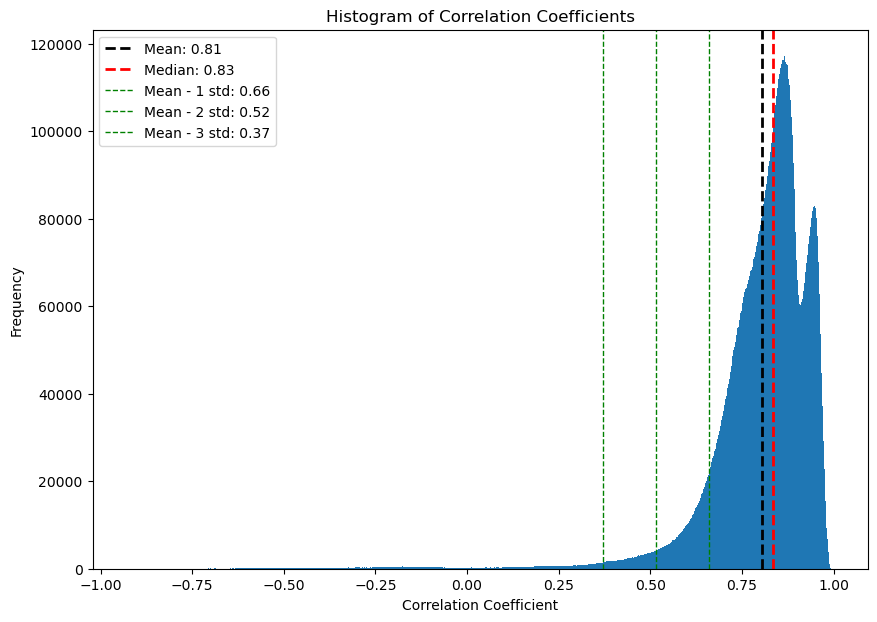

In [36]:
mafig, ax = plt.subplots(figsize =(10, 7))
ax.hist(masked_full.stack(), bins='auto')
plt.axvline(full_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {full_mean:.2f}')
plt.axvline(full_med, color='red', linestyle='dashed', linewidth=2, label=f'Median: {full_med:.2f}') 

for i in range(1, 4):
    dev = i * full_std
    plt.axvline(full_mean - dev, color='green', linestyle='dashed', linewidth=1, 
                label=f'Mean - {i} std: {full_mean - dev:.2f}')

plt.title('Histogram of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

# Add legend
plt.legend()
    
# Show plot
plt.show()

![](./data/full_corr_2.png)

That is the pairwise correlation for every single customer in the dataset with at least 30 non-null datapoints. What we want is the pairwise correlation for every customer currently labeled with a transformer flagged if it is below a certain level of correlation. But we can see that our data are NOT normally distributed. Chebyshev's inequality is probably more useful than anything based on Gaussian normality.

I think it makes sense to go transformer by transformer, so we're going to do it for one transformer then build a function to handle any number of transformers, storing the whole thing as a dictionary. The steps are more or less identical to what we did for the entire transformer-customer dataframe.

#### Building a Function for Finding Outliers

1. Select one transformer.

In [37]:
build = apc[apc['fldptag']=="2002000004779734"]

build.head()

,endpoint_id,sample_date,sample_point,voltage,fldptag
971,40035500,2023-05-01 00:15:00,1682918100,247.69,2002000004779734
972,40035500,2023-05-01 00:30:00,1682919000,247.94,2002000004779734
973,40035500,2023-05-01 00:45:00,1682919900,247.59,2002000004779734
974,40035500,2023-05-01 01:00:00,1682920800,247.57,2002000004779734
4286,40034408,2023-05-01 00:15:00,1682918100,247.35,2002000004779734


2. Set `index` to `sample_date`, even though it's not unique to every observation it enables the pivot we need.

In [38]:
build = build.set_index('sample_date')

3. The pivot gets us each columns voltage at the timestamp

In [39]:
pvt_bld = build.pivot(columns='endpoint_id', values='voltage')
pvt_bld

endpoint_id,31155283,40034408,40034427,40034431,40035500,40037147,40037154
sample_date,,,,,,,
2023-05-01 00:15:00,123.22,247.35,247.94,247.73,247.69,247.73,246.85
2023-05-01 00:30:00,123.50,247.41,247.87,247.40,247.94,247.26,246.47
2023-05-01 00:45:00,123.54,247.68,247.70,247.66,247.59,247.49,247.35
2023-05-01 01:00:00,123.43,247.55,247.85,247.88,247.57,248.06,247.31
2023-05-01 01:15:00,123.81,248.83,248.65,248.81,248.26,248.76,247.38
...,...,...,...,...,...,...,...
2023-05-04 03:00:00,NaN,NaN,NaN,NaN,246.99,247.47,NaN
2023-05-04 03:15:00,NaN,NaN,NaN,NaN,248.68,248.80,NaN
2023-05-04 03:30:00,NaN,NaN,NaN,NaN,248.51,248.55,NaN


4. Count the nulls.

In [40]:
pvt_bld.isnull().sum().sort_values(ascending=False)

endpoint_id
40034408    24
31155283    12
40034427    12
40034431    12
40037154    12
40035500     0
40037147     0
dtype: int64

It's pretty common for pivots to create a lot of null values. In general, we want at least 30 observations for the Central Limit Theorem to work its magic, but we are always limited by the data we have.

5. Get the pairwise Pearson correlation coefficients for every timeseries in the dataframe.

In [41]:
pvtd_corr = pvt_bld.corr()

In [42]:
pvtd_corr

endpoint_id,31155283,40034408,40034427,40034431,40035500,40037147,40037154
endpoint_id,,,,,,,
31155283,1.000000,0.976535,0.978287,0.978595,0.977973,0.975098,0.975603
40034408,0.976535,1.000000,0.978051,0.982057,0.978581,0.978711,0.976920
40034427,0.978287,0.978051,1.000000,0.982418,0.983571,0.980485,0.979891
40034431,0.978595,0.982057,0.982418,1.000000,0.982574,0.982677,0.981147
40035500,0.977973,0.978581,0.983571,0.982574,1.000000,0.983060,0.983023
40037147,0.975098,0.978711,0.980485,0.982677,0.983060,1.000000,0.982740
40037154,0.975603,0.976920,0.979891,0.981147,0.983023,0.982740,1.000000


6. Get trill indices.

In [43]:
tril_indices = np.tril_indices_from(pvtd_corr, k=-1)

In [44]:
tril_indices

(array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]),
 array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5]))

7. Get the correlations among the trill indices.

In [45]:
corr_values = pvtd_corr.values[tril_indices]

In [46]:
corr_values

array([0.9765352 , 0.97828653, 0.97805128, 0.97859472, 0.98205691,
       0.98241795, 0.97797263, 0.97858058, 0.98357094, 0.98257407,
       0.97509824, 0.97871061, 0.98048531, 0.98267723, 0.98305962,
       0.97560341, 0.9769201 , 0.97989104, 0.98114734, 0.98302266,
       0.98274008])

8. Extract the lower half of the triangle -- the ones below the diagonal of "1"s.

In [47]:
lower_triangle = pvtd_corr.where(np.tril(np.ones(pvtd_corr.shape), k=-1).astype(np.bool_))

9. Since we want to detect outliers automatically, we need to see the distribution. Everything above the diagonal is going to be a duplicate, so we just want below the diagonal.

In [48]:
masked = pvtd_corr.mask(np.triu(np.ones(pvtd_corr.shape, dtype=np.bool_)))

In [49]:
masked

endpoint_id,31155283,40034408,40034427,40034431,40035500,40037147,40037154
endpoint_id,,,,,,,
31155283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40034408,0.976535,NaN,NaN,NaN,NaN,NaN,NaN
40034427,0.978287,0.978051,NaN,NaN,NaN,NaN,NaN
40034431,0.978595,0.982057,0.982418,NaN,NaN,NaN,NaN
40035500,0.977973,0.978581,0.983571,0.982574,NaN,NaN,NaN
40037147,0.975098,0.978711,0.980485,0.982677,0.983060,NaN,NaN
40037154,0.975603,0.976920,0.979891,0.981147,0.983023,0.98274,NaN


10. Stacking means turning the whole dataframe into a large array.

In [50]:
corr_mean = masked.stack().mean()

corr_std = masked.stack().std()

corr_med = masked.stack().median()

In [51]:
masked[31155283].mean()

0.977015122260184

In [52]:
corr_mean - (corr_std * 2)

0.9745130369971337

11. Plot the distribution.

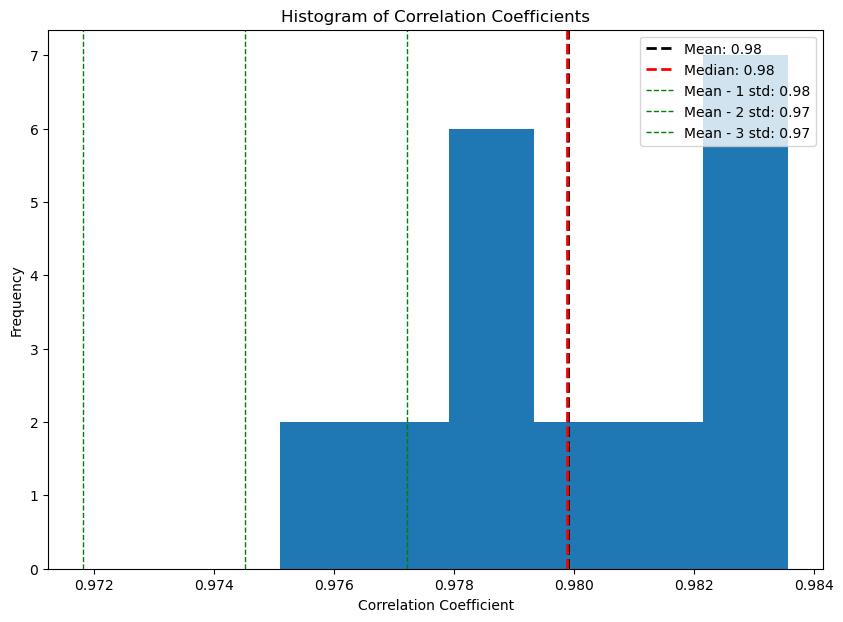

In [53]:
# Plot to see the distribution; not strictly necessary but we should always take a look at our data when we can
mafig, ax = plt.subplots(figsize =(10, 7))
ax.hist(masked.stack(), bins='auto')
plt.axvline(corr_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {corr_mean:.2f}')
plt.axvline(corr_med, color='red', linestyle='dashed', linewidth=2, label=f'Median: {corr_med:.2f}') 

for i in range(1, 4):
    dev = i * corr_std
    plt.axvline(corr_mean - dev, color='green', linestyle='dashed', linewidth=1, 
                label=f'Mean - {i} std: {corr_mean - dev:.2f}')

plt.title('Histogram of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

# Add legend
plt.legend()
    
# Show plot
plt.show()

12. Calculate the means to get the flagged correlations.

In [54]:
column_means = masked.mean()

In [55]:
flagged_correlations = column_means[column_means < (corr_mean - (1 * corr_std))].index

13. Build out the function.

In [56]:
def identify_outliers(transformer, std_threshold=1, null_threshold=35):
    """A function to identify customer whose voltmeter correlation coefficients are `threshold` standard
    deviations below the mean of all the coefficients associated with that transformer. Assumes the apc dataframe
    with columns 'endpoint_id', 'sample_date', 'sample_point', 'voltage', and 'fldptag'. Assumes 'sample_date' is 
    datetime object.
    
    Parameters
    ----------
    transformer - str; the id of a transformer; assumed to be 'fldptag'
    threshold - int; the number of standard deviations used to identify mislabeled pairings
    
    Returns
    ----------
    result - a dictionary whose key is `transformer` and whose value is a list of the flagged customers
    """
    # Filter the correct fldptag
    working = apc[apc['fldptag'] == transformer]
#     print(working)
    
    # Reset the index to datetime for the pivot
    working = working.set_index('sample_date')
#     print(working)
    
    # Create the pivot table using endpoint_id as column, voltage as values
    working = working.pivot(columns='endpoint_id', values='voltage')
#     print(working)
    
    # Drop nulls to slightly improve our correlations
    working = working.dropna(axis='columns', thresh=null_threshold)
    
    # Calculate the correlation matrix off the pivot table
    corr_matrix = working.corr()
#     print(corr_matrix)
    
    # Get values from below the diagonal, as an array for easy storage, calculation
    masked = corr_matrix.mask(np.triu(np.ones(corr_matrix.shape, dtype=np.bool_)))
#     print(masked)
    
    # Calculate the mean and standard deviation
    corr_mean = masked.stack().mean()
#     print(corr_mean)
    corr_std = masked.stack().std()
#     print(corr_std)
    column_means = masked.mean()
#     print("columns means: ", column_means)
    thresh_calc = std_threshold * corr_std
    
    # Apply the threshold to the correlation values
    flagged_correlations = column_means[column_means < (corr_mean - thresh_calc)].index
#     print(flagged_correlations)
    
    # Get the IDs
    flagged_customer_ids = list(flagged_correlations)
#     print(flagged_customer_ids)
    output = {
        'mean': corr_mean,
        'std': corr_std,
        'count_flagged':len(flagged_customer_ids),
        'flagged_ids': flagged_customer_ids
    }
#     print(output)
    return output

In [57]:
identify_outliers("2002000007674242", std_threshold=1, null_threshold=35)

{'mean': nan, 'std': nan, 'count_flagged': 0, 'flagged_ids': []}

14. From here, we can wrap the function in a loop and produce a dictionary containing all the transformers with outliers.

In [58]:
outlier_candidates = {}

for i in usable_transformers.index:
    outlier_candidates[i] = identify_outliers(i, 1, 35)

In [59]:
outlier_candidates

{'2002000001301384': {'mean': 0.8929822445818221,
  'std': 0.06364047552213203,
  'count_flagged': 1,
  'flagged_ids': [40042649]},
 '2002000002337116': {'mean': 0.982568507338806,
  'std': 0.0015351934452837806,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000002337117': {'mean': 0.982202591724469,
  'std': 0.001926724110520161,
  'count_flagged': 1,
  'flagged_ids': [40042503]},
 '2002000002337121': {'mean': 0.9702624196641576,
  'std': 0.012200934729103108,
  'count_flagged': 1,
  'flagged_ids': [40045147]},
 '2002000002337122': {'mean': 0.9780619906971508,
  'std': 0.004388252082522009,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000002337123': {'mean': 0.9741184831958014,
  'std': 0.01844062641181347,
  'count_flagged': 1,
  'flagged_ids': [40046445]},
 '2002000002337125': {'mean': 0.9824506156106344,
  'std': 0.0013405117545853273,
  'count_flagged': 1,
  'flagged_ids': [40039514]},
 '2002000002337129': {'mean': 0.9796182770869342,
  'std': 0.006912382242231602,
  'cou